In [1]:
# GraphQL and I/O related
from pprint import pprint
from graphql_helper import run_query
from gql import gql, Client
from gql.transport.aiohttp import AIOHTTPTransport
import json
import os

# statistical analysis
import pandas as pd
# from pandas import Timestamp
import numpy as np
# import seaborn as sns
import matplotlib.pyplot as plt
import datetime as dt
import math

In [2]:
uniswap_v3_subgraph_url = "https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v3"
refetch = True
data_folder = "data"
pool_day_data_folder = os.path.join(data_folder, "pool", "day")

In [3]:
TEN_LARGEST_TVL_POOLS_QUERY = """
{
    pools(first: 10, orderBy: totalValueLockedUSD, orderDirection: desc) {
        id
    } 
}
"""
if refetch:
    largest_tvl_pool_ids = run_query(uniswap_v3_subgraph_url, TEN_LARGEST_TVL_POOLS_QUERY)
    largest_tvl_pool_addrs = list(map(lambda x: x["id"], largest_tvl_pool_ids["data"]["pools"]))
    print(largest_tvl_pool_addrs)

['0xa850478adaace4c08fc61de44d8cf3b64f359bec', '0x5777d92f208679db4b9778590fa3cab3ac9e2168', '0x6c6bc977e13df9b0de53b251522280bb72383700', '0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8', '0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640', '0xc63b0708e2f7e69cb8a1df0e1389a98c35a76d52', '0x3416cf6c708da44db2624d63ea0aaef7113527c6', '0xcbcdf9626bc03e24f779434178a73a0b4bad62ed', '0x99ac8ca7087fa4a2a1fb6357269965a2014abc35', '0x4e68ccd3e89f51c3074ca5072bbac773960dfa36']


In [4]:
GET_POOL_BY_ID_QUERY = gql(
    """
    query getPoolById($pool_addr: ID!) {
        pool(id: $pool_addr) {
            tick
            token0 {
                symbol
                id
                decimals
            }
            token1 {
                symbol
                id
                decimals
            }
            feeTier
            sqrtPrice
            liquidity
        }
    }
    """
)

In [5]:
async def fetch_pools_metadata(addresses: list, verbose: bool=False):
    result = {"topPoolDatas": []}

    transport = AIOHTTPTransport(url=uniswap_v3_subgraph_url)

    async with Client(
        transport=transport,
        fetch_schema_from_transport=True,
    ) as session:
        for id in addresses:
            params = {"pool_addr": id}
            temp = await session.execute(GET_POOL_BY_ID_QUERY, variable_values=params)
            result["topPoolDatas"].append(temp["pool"])

    if verbose:
        pprint(result)

    if not os.path.exists(data_folder):
        os.makedirs(data_folder)

    with open(f"{data_folder}/topPoolDatas.json", "w") as f:
        json.dump(result, f, indent=4)

In [6]:
if refetch:
    await fetch_pools_metadata(largest_tvl_pool_addrs)

In [7]:
with open(f"{data_folder}/topPoolDatas.json", "r") as f:
    top_pool_datas = json.load(f)

token_symbols = dict()

# replace nested dict with token addr
for pool_dict in top_pool_datas["topPoolDatas"]:
    for token in ["token0", "token1"]:
        token_symbols[pool_dict[token]["id"]] = pool_dict[token]["symbol"]
        pool_dict[token] = pool_dict[token]["id"]

top_pools_df = pd.DataFrame.from_dict(top_pool_datas["topPoolDatas"]).astype({
    "token0": str,
    "token1": str,
    "feeTier": int
})
top_pools_df["pool_addr"] = largest_tvl_pool_addrs
top_pools_df.drop(columns=["tick"], inplace=True)

top_pools_df.head()

,token0,token1,feeTier,sqrtPrice,liquidity,pool_addr
0,0x12b32f10a499bf40db334efe04226cca00bf2d9b,0x5ed60a121159481675bad3e648ba4c89753e056f,500,792049440195001924670217089101,1706245281880037395956227425,0xa850478adaace4c08fc61de44d8cf3b64f359bec
1,0x6b175474e89094c44da98b954eedeac495271d0f,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,100,79230071477662371997706,3085454137186020969830698,0x5777d92f208679db4b9778590fa3cab3ac9e2168
2,0x6b175474e89094c44da98b954eedeac495271d0f,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,500,79229635282533304034492,348092709278906135509606,0x6c6bc977e13df9b0de53b251522280bb72383700
3,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,3000,2353376039515840592150516330544501,2858956505791966125,0x8ad599c3a0ff1de082011efddc58f1908eb6e6d8
4,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,500,2351893002831559374820632319715104,3822239080916856093,0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640


In [8]:
top_pools_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10 entries, 0 to 9
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   token0     10 non-null     object
 1   token1     10 non-null     object
 2   feeTier    10 non-null     int32 
 3   sqrtPrice  10 non-null     object
 4   liquidity  10 non-null     object
 5   pool_addr  10 non-null     object
dtypes: int32(1), object(5)
memory usage: 568.0+ bytes


In [9]:
def poolkey2str(token0: str, token1: str, fee_tier: int) -> str:
    return token_symbols[token0] + "/" + token_symbols[token1] + "(" + str(fee_tier / 10000) + "%)"

### Replicating the Info Page
We perform the following two queries over 1000 days (at most):
1. TVL
2. 24H Volume

In [10]:
POOL_CHART = gql(
    """
    query poolDayDatas($startTime: Int!, $skip: Int!, $address: String!) {
        poolDayDatas(
            first: 1000
            skip: $skip
            where: { pool: $address, date_gt: $startTime }
            orderBy: date
            orderDirection: asc
            subgraphError: allow
        ) {
            date
            volumeUSD
            tvlUSD
            feesUSD
        }
    }
    """
)

In [11]:
fetch_pool_error = []

# ref: https://github.com/Uniswap/v3-info/blob/770a05dc1a191cf229432ebc43c1f2ceb3666e3b/src/data/pools/chartData.ts#L14
async def fetch_pool_chart_data(address: str, symbol0: str, symbol1: str, fee_tier: int, verbose: bool=False):
    START_TIMESTAMP = 1619170975 # GMT: Friday, April 23, 2021 9:42:55 AM
    # END_TIMESTAMP = int(time.time()) # current timestamp

    error = False
    skip = 0
    all_found = False
    result = {"poolDayDatas": []}

    transport = AIOHTTPTransport(url=uniswap_v3_subgraph_url)

    async with Client(
        transport=transport,
        fetch_schema_from_transport=True,
    ) as session:
        params = {
            "address": address,
            "startTime": START_TIMESTAMP,
            "skip": skip
        }
        try:
            while not all_found:
                temp = await session.execute(POOL_CHART, variable_values=params)
                skip += 1000
                if len(temp["poolDayDatas"]) < 1000 or error:
                    all_found = True
                if temp:
                    result["poolDayDatas"] = result["poolDayDatas"] + temp["poolDayDatas"] # concat the lists
        except Exception as e:
            print(e)
            error = True
            fetch_pool_error.append(address)

    if not error:
        if verbose:
            pprint(result)

        if not os.path.exists(pool_day_data_folder):
            os.makedirs(pool_day_data_folder)

        with open(f"{pool_day_data_folder}/{symbol0}_{symbol1}_{fee_tier}.json", "w") as f:
            json.dump(result, f, indent=4)

In [12]:
if refetch:
    for i, row in top_pools_df.iterrows():
        await fetch_pool_chart_data(row["pool_addr"], token_symbols[row["token0"]], token_symbols[row["token1"]], row["feeTier"])
    print(fetch_pool_error)


['0x88e6a0c2ddd26feeb64f039a2c41296fcb3f5640']


In [13]:
# reads pool day datas from json
df = pd.DataFrame(columns=["date"])
pool_names = []

for f in os.listdir(pool_day_data_folder):
    fullname = os.fsdecode(f)

    # not a rigorous check
    with open(os.path.join(pool_day_data_folder, fullname), "r") as file:
        pool_day_datas = json.load(file)

    # parse dict as df
    temp = pd.DataFrame.from_dict(pool_day_datas["poolDayDatas"]).astype({
        "volumeUSD": np.float64,
        "tvlUSD": np.float64
    })

    # Note: there is no need to analyze fees separately,
    # as it is a fixed proportion of the pool's trade volume
    temp.drop(columns=["feesUSD"], inplace=True)

    # prefix columns (except "date") with pool name
    cols = temp.columns[~temp.columns.isin(["date"])]
    pool_name = fullname.split(os.sep)[-1].split(".")[0]
    pool_names.append(pool_name)
    temp.rename(columns = dict(zip(cols, pool_name + "_" + cols)), inplace=True)

    # outer join: union of items on "date"
    df = pd.merge(df, temp, how="outer", on=["date"])

df.head()

,date,DAI_USDC_100_volumeUSD,DAI_USDC_100_tvlUSD,DAI_USDC_500_volumeUSD,DAI_USDC_500_tvlUSD,FRAX_USDC_500_volumeUSD,FRAX_USDC_500_tvlUSD,UMIIE_UMIIE2_500_volumeUSD,UMIIE_UMIIE2_500_tvlUSD,USDC_USDT_100_volumeUSD,USDC_USDT_100_tvlUSD,USDC_WETH_3000_volumeUSD,USDC_WETH_3000_tvlUSD,WBTC_USDC_3000_volumeUSD,WBTC_USDC_3000_tvlUSD,WBTC_WETH_3000_volumeUSD,WBTC_WETH_3000_tvlUSD,WETH_USDT_3000_volumeUSD,WETH_USDT_3000_tvlUSD
0,1636761600,4.513846e+05,1.966993e+05,8.954913e+06,1.351651e+08,6.513284e+06,1.421463e+08,NaN,NaN,0.000000e+00,0.000000e+00,3.258303e+07,3.221663e+08,5.558921e+06,8.458455e+07,6.865357e+06,3.844793e+08,2.133148e+07,1.647156e+08
1,1636848000,3.046430e+05,2.080345e+05,2.429848e+07,1.351848e+08,1.305352e+07,1.382102e+08,NaN,NaN,1.171537e+07,1.464872e+07,6.006904e+07,3.245487e+08,8.563428e+06,8.618498e+07,1.476070e+07,3.867895e+08,3.095344e+07,1.631154e+08
2,1636934400,4.836127e+05,2.080810e+05,1.278452e+07,1.279762e+08,1.679448e+07,1.397692e+08,NaN,NaN,6.397272e+07,1.468092e+07,6.370150e+07,3.281267e+08,9.053309e+06,8.483084e+07,2.202722e+07,3.794292e+08,3.879067e+07,1.631893e+08
3,1637020800,4.258826e+06,2.085063e+05,5.474165e+07,1.564352e+08,9.468480e+06,1.447372e+08,NaN,NaN,1.198162e+08,2.311258e+07,1.930420e+08,3.216873e+08,3.018787e+07,9.267628e+07,4.721473e+07,3.564911e+08,8.431852e+07,1.605809e+08
4,1637107200,4.331535e+07,7.504938e+06,2.535313e+07,1.906889e+08,7.385819e+06,1.479893e+08,NaN,NaN,1.393051e+08,1.355256e+08,1.066171e+08,3.473285e+08,2.063582e+07,9.248757e+07,2.804825e+07,3.582874e+08,2.788640e+07,1.613374e+08


In [14]:
# ["date"]: int -> date (in "YYYY-MM-DD")
df["timestamp"] = df["date"] # keep timestamp in a new col
df["date"] = df["date"].map(dt.date.fromtimestamp)

df.head()

,date,DAI_USDC_100_volumeUSD,DAI_USDC_100_tvlUSD,DAI_USDC_500_volumeUSD,DAI_USDC_500_tvlUSD,FRAX_USDC_500_volumeUSD,FRAX_USDC_500_tvlUSD,UMIIE_UMIIE2_500_volumeUSD,UMIIE_UMIIE2_500_tvlUSD,USDC_USDT_100_volumeUSD,USDC_USDT_100_tvlUSD,USDC_WETH_3000_volumeUSD,USDC_WETH_3000_tvlUSD,WBTC_USDC_3000_volumeUSD,WBTC_USDC_3000_tvlUSD,WBTC_WETH_3000_volumeUSD,WBTC_WETH_3000_tvlUSD,WETH_USDT_3000_volumeUSD,WETH_USDT_3000_tvlUSD,timestamp
0,2021-11-13,4.513846e+05,1.966993e+05,8.954913e+06,1.351651e+08,6.513284e+06,1.421463e+08,NaN,NaN,0.000000e+00,0.000000e+00,3.258303e+07,3.221663e+08,5.558921e+06,8.458455e+07,6.865357e+06,3.844793e+08,2.133148e+07,1.647156e+08,1636761600
1,2021-11-14,3.046430e+05,2.080345e+05,2.429848e+07,1.351848e+08,1.305352e+07,1.382102e+08,NaN,NaN,1.171537e+07,1.464872e+07,6.006904e+07,3.245487e+08,8.563428e+06,8.618498e+07,1.476070e+07,3.867895e+08,3.095344e+07,1.631154e+08,1636848000
2,2021-11-15,4.836127e+05,2.080810e+05,1.278452e+07,1.279762e+08,1.679448e+07,1.397692e+08,NaN,NaN,6.397272e+07,1.468092e+07,6.370150e+07,3.281267e+08,9.053309e+06,8.483084e+07,2.202722e+07,3.794292e+08,3.879067e+07,1.631893e+08,1636934400
3,2021-11-16,4.258826e+06,2.085063e+05,5.474165e+07,1.564352e+08,9.468480e+06,1.447372e+08,NaN,NaN,1.198162e+08,2.311258e+07,1.930420e+08,3.216873e+08,3.018787e+07,9.267628e+07,4.721473e+07,3.564911e+08,8.431852e+07,1.605809e+08,1637020800
4,2021-11-17,4.331535e+07,7.504938e+06,2.535313e+07,1.906889e+08,7.385819e+06,1.479893e+08,NaN,NaN,1.393051e+08,1.355256e+08,1.066171e+08,3.473285e+08,2.063582e+07,9.248757e+07,2.804825e+07,3.582874e+08,2.788640e+07,1.613374e+08,1637107200


In [15]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 407 entries, 0 to 406
Data columns (total 20 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   date                        407 non-null    object 
 1   DAI_USDC_100_volumeUSD      214 non-null    float64
 2   DAI_USDC_100_tvlUSD         214 non-null    float64
 3   DAI_USDC_500_volumeUSD      407 non-null    float64
 4   DAI_USDC_500_tvlUSD         407 non-null    float64
 5   FRAX_USDC_500_volumeUSD     385 non-null    float64
 6   FRAX_USDC_500_tvlUSD        385 non-null    float64
 7   UMIIE_UMIIE2_500_volumeUSD  4 non-null      float64
 8   UMIIE_UMIIE2_500_tvlUSD     4 non-null      float64
 9   USDC_USDT_100_volumeUSD     214 non-null    float64
 10  USDC_USDT_100_tvlUSD        214 non-null    float64
 11  USDC_WETH_3000_volumeUSD    407 non-null    float64
 12  USDC_WETH_3000_tvlUSD       407 non-null    float64
 13  WBTC_USDC_3000_volumeUSD    406 non

In [16]:
# sanity check for number of days elapsed
print(df["date"][0], "to", dt.date.today(), "has", (dt.date.today() - df["date"][0]))

2021-11-13 to 2022-06-14 has 213 days, 0:00:00


## 24H Volume Analysis

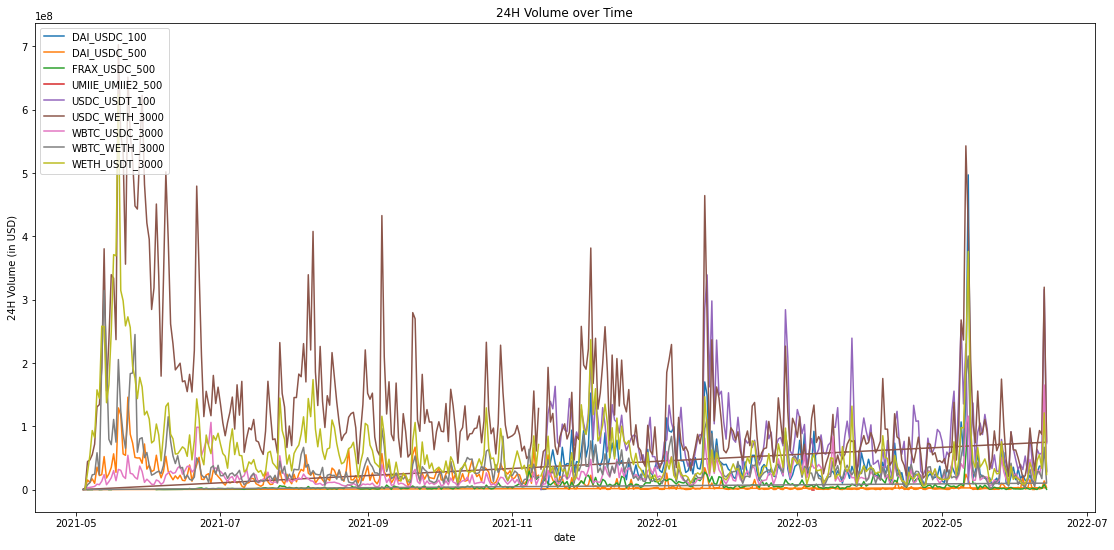

In [17]:
plt.figure(figsize=(19, 9))
for pool_name in pool_names:
    plt.plot(df["date"], df[pool_name + "_volumeUSD"])
plt.title("24H Volume over Time")
plt.xlabel("date")
plt.ylabel("24H Volume (in USD)")
plt.legend(pool_names, loc='upper left')
plt.show()

In [18]:
# find the days with the greatest 24H volumes
# df.sort_values(by="volumeUSD", ascending=False)[:10]

In [19]:
# # for reference only, no use now
# fig, ax = plt.subplots(figsize=(15, 1))
# sns.boxplot(data=df, x="volumeUSD")
# plt.xlim(0, 2e8)
# plt.show()

### Histogram
Observe the distribution of the prices.

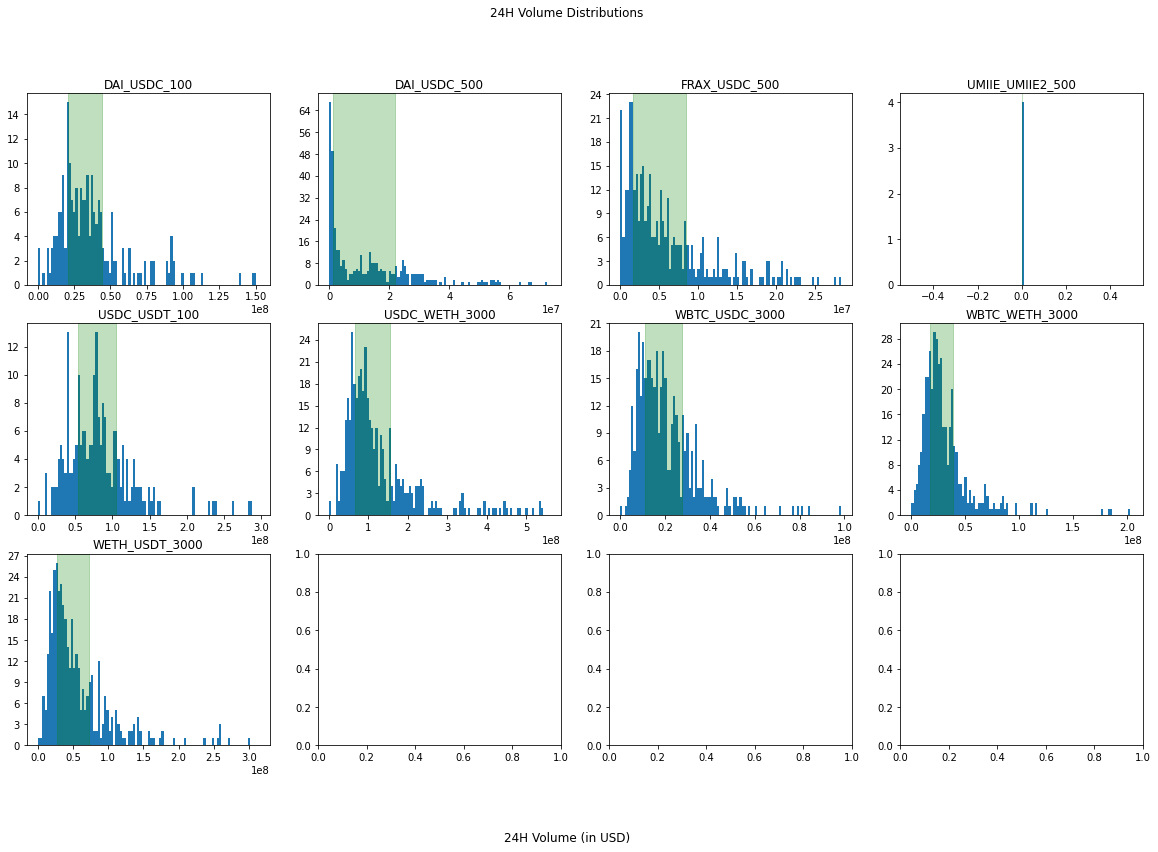

In [50]:
from matplotlib.pyplot import MaxNLocator

fig = plt.figure(figsize=(20, 12))
axes = fig.subplots(3, 4)
for i, pool_name in enumerate(pool_names):
    volumeUSD_series = df[pool_name + "_volumeUSD"]
    ax = axes[math.floor(i/4), i%4]
    ax.title.set_text(pool_name)
    ax.hist(volumeUSD_series, bins=100, range=(0, volumeUSD_series.quantile(0.99)))

    # force y-axis ticks to use integers
    ax.get_yaxis().set_major_locator(MaxNLocator(integer=True))

    # highlight 25%-75% percentile
    lq = volumeUSD_series.quantile(0.25)
    uq = volumeUSD_series.quantile(0.75)
    ax.axvspan(lq, uq, color="green", alpha=0.25)

fig.suptitle("24H Volume Distributions")
fig.supxlabel("24H Volume (in USD)")
plt.show()

In [51]:
pool_df = df.drop(columns="timestamp")
# note: df.std() is normalized by N-1
pool_metrics_df = pd.DataFrame(data=[pool_df.mean(), pool_df.std()], index=["mean", "stdev"])
pool_metrics_df

C:\Users\user\AppData\Local\Temp\ipykernel_8892\2952147379.py:3: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  pool_metrics_df = pd.DataFrame(data=[pool_df.mean(), pool_df.std()], index=["mean", "stdev"])


,DAI_USDC_100_volumeUSD,DAI_USDC_100_tvlUSD,DAI_USDC_500_volumeUSD,DAI_USDC_500_tvlUSD,FRAX_USDC_500_volumeUSD,FRAX_USDC_500_tvlUSD,UMIIE_UMIIE2_500_volumeUSD,UMIIE_UMIIE2_500_tvlUSD,USDC_USDT_100_volumeUSD,USDC_USDT_100_tvlUSD,USDC_WETH_3000_volumeUSD,USDC_WETH_3000_tvlUSD,WBTC_USDC_3000_volumeUSD,WBTC_USDC_3000_tvlUSD,WBTC_WETH_3000_volumeUSD,WBTC_WETH_3000_tvlUSD,WETH_USDT_3000_volumeUSD,WETH_USDT_3000_tvlUSD
mean,4.055128e+07,2.538573e+08,1.422944e+07,1.061193e+08,6.496411e+06,1.498877e+08,0.0,6.853934e+10,8.612219e+07,1.790297e+08,1.330112e+08,3.372826e+08,2.204872e+07,8.567265e+07,3.438259e+07,2.610970e+08,6.039706e+07,1.532450e+08
stdev,4.212606e+07,1.880489e+08,1.817964e+07,5.473771e+07,8.709025e+06,9.698975e+07,0.0,1.286305e+11,5.404470e+07,4.962319e+07,1.121680e+08,7.543098e+07,1.766062e+07,3.742849e+07,3.422683e+07,7.599316e+07,6.177463e+07,3.391152e+07


In [52]:
# # for reference only, no use now
# df["volumeUSD"].plot.kde()
# plt.title(pool_name + " 24H Volume KDE")
# plt.xlim(0, 2e8)
# plt.show()

In [53]:
# TODO: time series / autocorelation
# TODO: aggregate weekly and daily patterns and look for anomalies (e.g. Friday)
# TODO: ask for calculation of Greeks (Detla, Vega...)

### Fast Fourier Transform (FFT)
FFT computes the frequency content of the prices as signals.

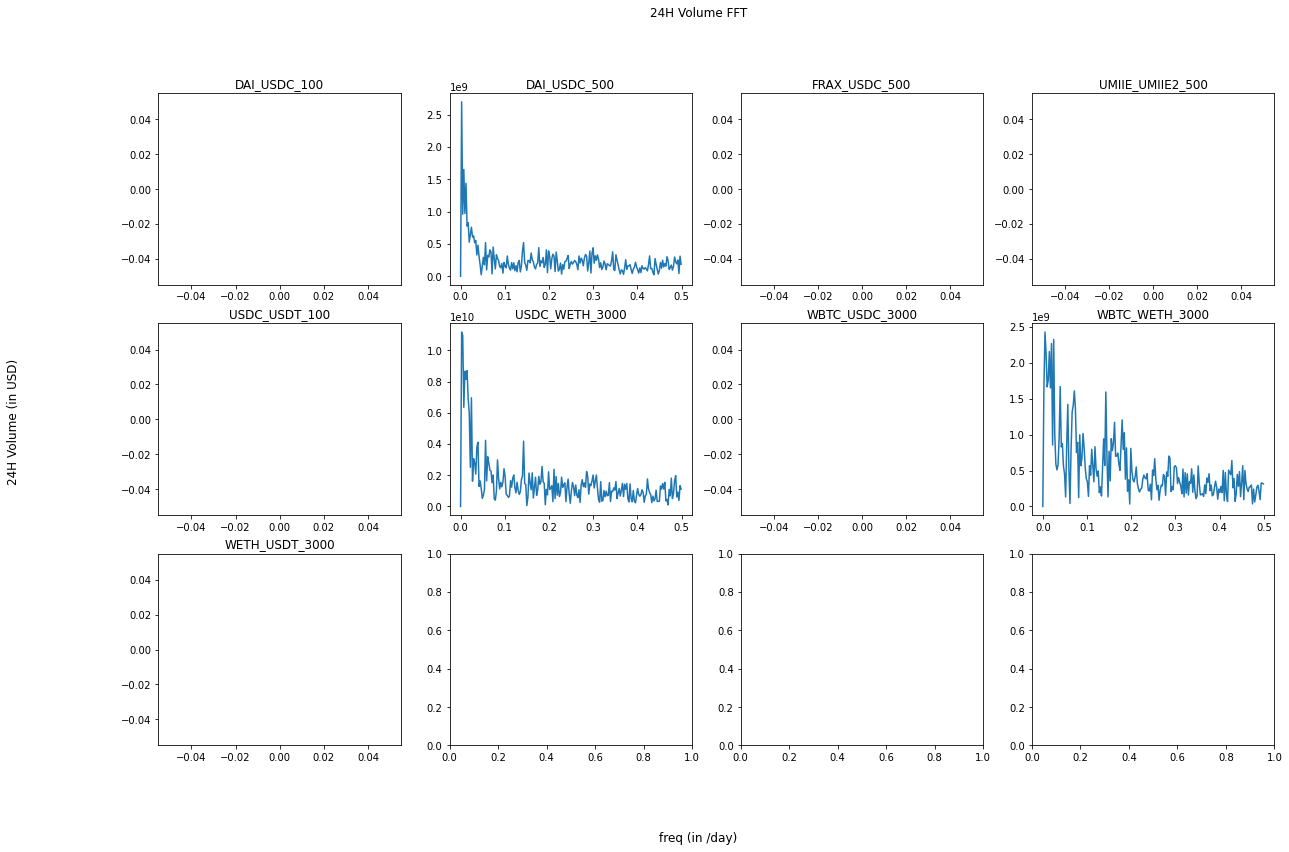

In [58]:
fig = plt.figure(figsize=(20, 12))
axes = fig.subplots(3, 4)
for i, pool_name in enumerate(pool_names):
    volumeUSD_series = df[pool_name + "_volumeUSD"]

    # only keep those with freq >= 0
    # Y = abs(np.fft.fft(volumeUSD_series))[0:math.ceil(df.shape[0]/2)]
    Y = abs(np.fft.fft(volumeUSD_series - volumeUSD_series.mean()))[0:math.ceil(df.shape[0]/2)]
    freq = np.fft.fftfreq(df.shape[0], 1)[0:math.ceil(df.shape[0]/2)]

    ax = axes[math.floor(i/4), i%4]
    ax.title.set_text(pool_name)
    ax.plot(freq, Y)

fig.suptitle("24H Volume FFT")
fig.supxlabel("freq (in /day)")
fig.supylabel("24H Volume (in USD)")
plt.show()

In [ ]:
# get the list of spectrums
spectrum = Y.real*Y.real + Y.imag*Y.imag
nspectrum = spectrum / spectrum[0]

# plot nspectrum per frequency, with a semilog scale on nspectrum
plt.semilogy(freq, nspectrum)
plt.title(pool_name + " 24H Volume FFT (Semilog y)")
plt.xlabel("freq (in /day)")
plt.ylabel("log(24H Volume)")
plt.show()

## TVL Analysis

In [59]:
import pwlf_helper
# reg_result = pwlf_helper.regression(df["timestamp"], df["tvlUSD"], 6)
reg_result = pwlf_helper.regression(df["timestamp"], df["DAI_USDC_500" + "_tvlUSD"], 6)

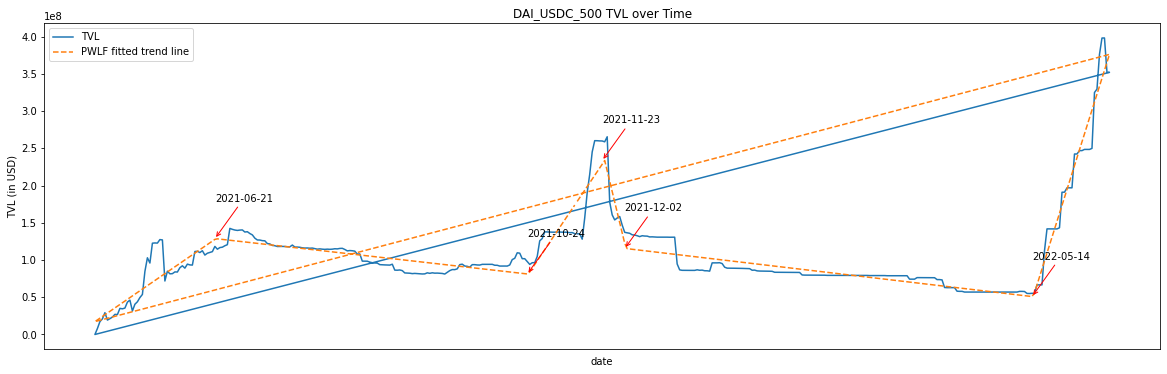

In [62]:
fig, ax = plt.subplots(figsize=(20, 6))
plt.plot(df["date"], df["DAI_USDC_500" + "_tvlUSD"])
plt.plot(df["date"], reg_result.yHat, '--')

plt.title("DAI_USDC_500" + " TVL over Time")
plt.xlabel("date")
plt.ylabel("TVL (in USD)")
plt.legend(["TVL", "PWLF fitted trend line"])

# x-axis ticks are spaced out biweekly (for now)
plt.xticks(pd.date_range(df["date"].iloc[0], df["date"].iloc[-1], freq="14D"))

# annotate turning points
for tp in reg_result.tp[1:-1]:
    tp_date = dt.date.fromtimestamp(tp)
    tp_str = tp_date.strftime("%Y-%m-%d")
    pred = reg_result.predict(tp)
    ax.annotate(tp_str, xy=(tp_date, pred), xytext=(tp_date, pred+0.5e8),
        arrowprops=dict(arrowstyle="->", color='red')
    )

plt.show()